In [1]:
# DESCRIPTION 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


In [3]:
# Read the files
item_df = pd.read_csv("data/items.csv")
categories_df = pd.read_csv("data/category_trans.csv")
shops_df = pd.read_csv("data/shop_trans.csv")
sales_df = pd.read_csv("data/sales_train.csv")

In [4]:
# change the dateformat
sales_df["date"] = pd.to_datetime(sales_df["date"], infer_datetime_format=True)

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [6]:
# get the aggreate monthly sales
monthly_sales = sales_df.groupby(['date_block_num', 'shop_id', 'item_id'])['date', 'item_price','item_cnt_day'].agg({"date": ['min', 'max'], 'item_cnt_day':'sum', 'item_price':'mean'})

In [7]:
monthly_sales.head()

date            item_cnt_day item_price
                                      min        max          sum       mean
date_block_num shop_id item_id                                              
0              0       32      2013-01-21 2013-03-01          6.0      221.0
                       33      2013-01-17 2013-03-01          3.0      347.0
                       35      2013-01-31 2013-01-31          1.0      247.0
                       43      2013-01-31 2013-01-31          1.0      221.0
                       51      2013-01-13 2013-01-31          2.0      128.5

### Time Series Analysis
- We are required to to predict the next month sales per given item id and shop id

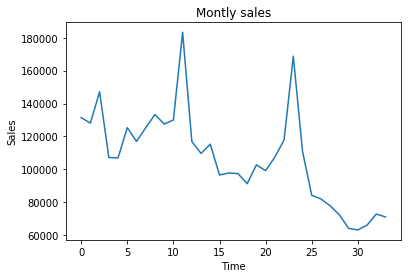

In [8]:
# get the monthly sales of all the items
ts = sales_df.groupby(["date_block_num"])["item_cnt_day"].sum()
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title("Montly sales")
plt.plot(ts)

#### 1. Check if tha data is stationary 
A Time Series is said to be stationary if the mean, variance **remains constant** over time.

We use two methods to check the stationary of the data:-
    1. ADCF(Augmented Dicky Fuller Test) Test:-
        In this case, if the **Test Statistics** is less than the **Critical Value**, the data is stationary.
    2. Rolling statistics

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationary(timeseries_df):

    # determining rolling statictics
    rolmean = timeseries_df.rolling(window=12).mean() # window 12, monthly
    
    rolstd = timeseries_df.rolling(window=12).std()
    
    # ploting rolling
    origi = plt.plot(timeseries_df, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling mean")
    std = plt.plot(rolstd, color="black", label="Rolling std")
    plt.legend(loc='best')
    plt.title("rolling statistics")
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print("results of ADFC test")
    dftest = adfuller(timeseries_df, autolag="AIC")
    print(dftest)
    dfoutput = pd.Series(dftest[0:4], index=["Test statistics", "p-value", "#lags Used", "Number of observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical value (%s)" %key] = value
    print(dfoutput)

/Users/rose/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


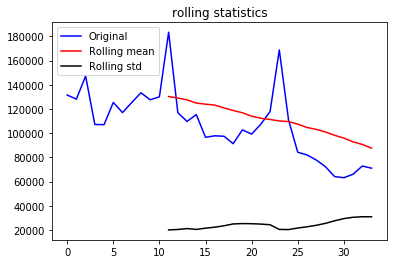

results of ADFC test
(-2.3957040669944325, 0.1429525769929046, 0, 33, {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}, 530.9537360897348)
Test statistics                -2.395704
p-value                         0.142953
#lags Used                      0.000000
Number of observations Used    33.000000
Critical value (1%)            -3.646135
Critical value (5%)            -2.954127
Critical value (10%)           -2.615968
dtype: float64


In [10]:
test_stationary(ts)

The test statistics is not less than any of the critical values, therefore we can conclude that the data **is not** stationary

#### Make the data Stationary

###### 1.0 Eliminate trend
  **Differencing** - Take the difference in a particular time lag

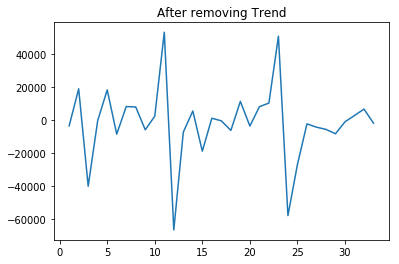

In [11]:
ts_shift = ts - ts.shift()
plt.title("After removing Trend")
plt.plot(ts_shift)


We can use the above function or create a differencing function

In [12]:
from pandas import Series as Series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval] # get the difference of the data at and index and the previous index
        diff.append(value)
    return Series(diff)

# inverse the difference
def inverse_difference(last_ob, value):
    return value + last_ob

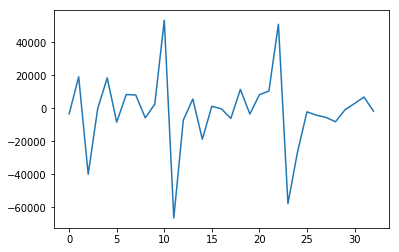

In [13]:
ts_detrend = difference(ts)
plt.plot(ts_detrend)

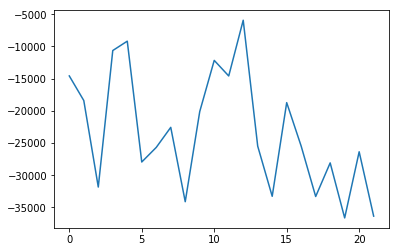

In [14]:
ts_deseason = difference(ts, 12)
plt.plot(ts_deseason)

Test the staionality ofter removing seasonality

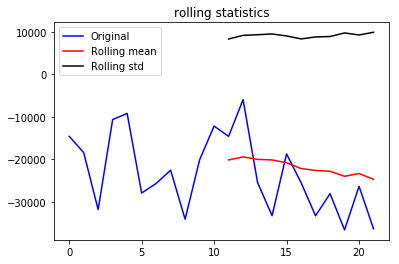

results of ADFC test
(-3.2701011928155483, 0.01626900992370421, 0, 21, {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}, 255.63859029094408)
Test statistics                -3.270101
p-value                         0.016269
#lags Used                      0.000000
Number of observations Used    21.000000
Critical value (1%)            -3.788386
Critical value (5%)            -3.013098
Critical value (10%)           -2.646397
dtype: float64


In [15]:
test_stationary(ts_deseason)

**Decomposition** - modelling both trend and seaonality and removing them from the model.

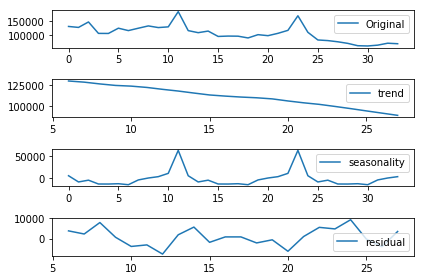

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts.values, freq=12, model="adaptive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label="Original")
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label="trend")
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label="seasonality")
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label="residual")
plt.legend(loc='best')
plt.tight_layout()

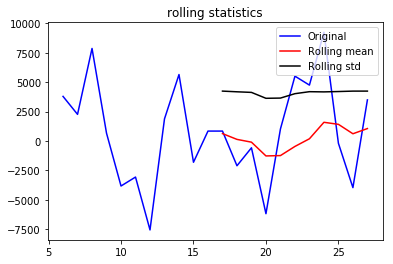

results of ADFC test
(0.7498288717858399, 0.990781592010807, 9, 12, {'1%': -4.137829282407408, '5%': -3.1549724074074077, '10%': -2.7144769444444443}, 236.35930915095528)
Test statistics                 0.749829
p-value                         0.990782
#lags Used                      9.000000
Number of observations Used    12.000000
Critical value (1%)            -4.137829
Critical value (5%)            -3.154972
Critical value (10%)           -2.714477
dtype: float64


In [21]:
ts_decomposed = pd.DataFrame(residual)
ts_decomposed.dropna(inplace=True)
ts_decomposed
test_stationary(ts_decomposed.iloc[:,0])

When using the addictive model the test statistics is still high, but multiplacative model improves the stationarity, but again the curves changes.